In [1]:
import torch

from lafomo.datasets import P53Data
from lafomo.variational.models import SingleLinearLFM
from lafomo.variational.trainer import P53ConstrainedTrainer
from lafomo.options import VariationalOptions
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

from fenics import *
from fenics_adjoint import *

import torch_fenics

,t,x,U,Y
0,0.000,0.0,0.978006,0.0
1,0.025,0.0,1.009034,0.0
2,0.050,0.0,1.006165,0.0
3,0.075,0.0,0.967695,0.0
4,0.100,0.0,0.893023,0.0


Text(0, 0.5, 'distance')

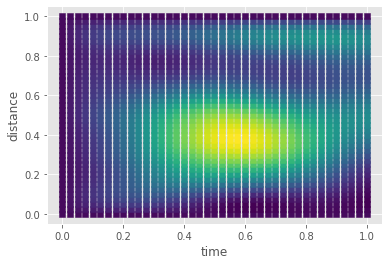

In [189]:
import numpy as np

import pandas as pd
data = pd.read_csv('../data/demToy1GPGene.csv')
data = pd.read_csv('../data/demToy1GPmRNA.csv')

display(data.head(5))

vals = data.values

In [192]:
T = 1.0            # final time
num_steps = 40     # number of time steps
dt = T / num_steps # time step size

# Declare the FEniCS model corresponding to solving the Poisson equation
# with variable source term and boundary value
class Poisson(torch_fenics.FEniCSModule):
    # Construct variables which can be in the constructor
    def __init__(self):
        # Call super constructor
        super().__init__()

        self.sensitivity = 1.0
        self.decay = 0.1
        self.diffusion = 0.01
        # Create function space
        nx = ny = 30
        mesh = UnitIntervalMesh(40)
        self.V = FunctionSpace(mesh, 'P', 1)

        # Create trial and test functions
        y = TrialFunction(self.V)
        self.v = TestFunction(self.V)

        # Construct bilinear form
        self.a = (1 + dt * self.decay) * y * self.v * dx +\
                 dt * self.diffusion * inner(grad(y), grad(self.v)) * dx

    def solve(self, y_prev, u):#, g):

        # Construct linear form
        # L = f * self.v * dx
        # (u_n + dt*f)*v*dx
        # L = (u_n + dt * f) * self.v * dx
        L = (y_prev + dt * self.sensitivity * u) * self.v * dx

        # Construct boundary condition
        bc = DirichletBC(self.V, Constant(0), 'on_boundary')

        # Solve the Poisson equation
        y = Function(self.V)
        solve(self.a == L, y, bc)

        # Update u_n
        # self.u_n.assign(u)
        # Return the solution
        return y

    def input_templates(self):
        # Declare templates for the inputs to Poisson.solve
        return Function(self.V), Function(self.V)

In [219]:
poisson = Poisson()
us = list()
y_prev = torch.zeros((1, 41), requires_grad=True, dtype=torch.float64)
t = 0.0
t_index = 0
ts = data['t'].values

for n in range(num_steps+1):
    u = data[data['t'] == ts[t_index]]['U'].values
    u = torch.tensor(u).unsqueeze(0)
    t_index += 1
    t += dt

    y_prev = poisson(y_prev, u)
    # y_prev shape (N, 21)
    us.append(y_prev.detach())

us = torch.stack(us).permute(1, 0, 2)  # shape (batch, times, distance)
print(us.shape)

torch.Size([1, 41, 41])


torch.Size([1, 41, 41])


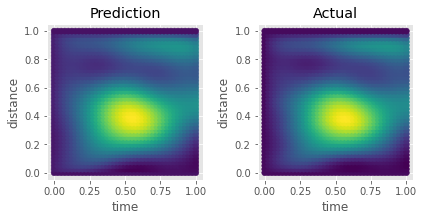

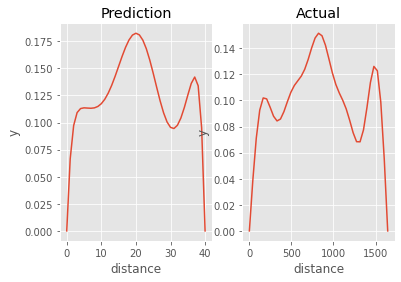

In [222]:
def plot_output(ax, output, title=None):
    ax.set_title(title)
    ax.plot(output)
    ax.set_xlabel('distance')
    ax.set_ylabel('y')
def scatter_output(ax, output, title=None):
    ax.set_title(title)
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=output)
    ax.set_xlabel('time')
    ax.set_ylabel('distance')
    ax.set_aspect('equal')

fig, axes = plt.subplots(ncols=2)
print(us.shape)
scatter_output(axes[0], us.transpose(1, 2).reshape(-1), 'Prediction')
scatter_output(axes[1], data.iloc[:, 3], 'Actual')
plt.tight_layout()
fig, axes = plt.subplots(ncols=2)
plot_output(axes[0], us[0, 4, :], 'Prediction')
plot_output(axes[1], data[data['t'] == ts[4]].iloc[:, 3], 'Actual')

Text(0, 0.5, 'u')

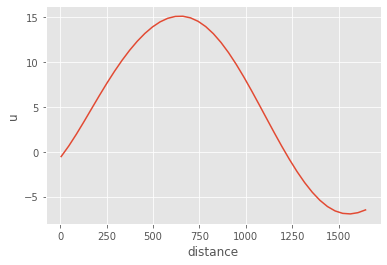

In [94]:
plt.plot(data[data['t'] == ts[5]].iloc[:, 2])
plt.xlabel('distance')
plt.ylabel('u')

In [ ]:
# Create N sets of input
N = 10
f = torch.rand(N, 1, requires_grad=True, dtype=torch.float64)
g = torch.rand(N, 1, requires_grad=True, dtype=torch.float64)
print(f.shape)
#g are the boundary conditions
# Solve the Poisson equation N times
u = poisson(f)

In [ ]:
from fenics import *
import time

T = 2.0            # final time
num_steps = 50     # number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(0, 0), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Constant(1)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

a = u*v*dx + dt*dot(grad(u), grad(v))*dx

# Create VTK file for saving solution
vtkfile = File('heat_gaussian/solution.pvd')

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):
    L = (u_n + dt*f)*v*dx

    # Update current time
    t += dt

    # Compute solution
    solve(a == L, u, bc)

    # Save to file and plot solution
    vtkfile << (u, t)
    # plot(u)


    # Update previous solution
    u_n.assign(u)

# Hold plot

<class 'dolfin.function.function.Function'>


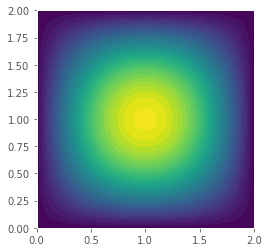

In [94]:
plot(u)
print(type(u))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


AttributeError: 'dolfin.cpp.la.PETScVector' object has no attribute 'array'

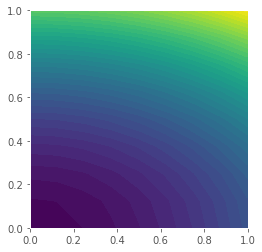

In [97]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)

    # Plot solution
    plot(u)

    # Compute error at vertices
    u_e = interpolate(u_D, V)
    error = np.abs(u_e.vector().array() - u.vector().array()).max()
    print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)

# Hold plot
